# Lab 7.1: Introduction to MNIST

**Jonathan Choi 2021**

**[Deep Learning By Torch] End to End study scripts of Deep Learning by implementing code practice with Pytorch.**

If you have an any issue, please PR below.

[[Deep Learning By Torch] - Github @JonyChoi](https://github.com/jonychoi/Deep-Learning-By-Torch)

## Imports

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

### Take a Moment!

**TORCHVISION.TRANSFORMS**

Transforms are common image transformations. They can be chained together using Compose. Most transform classes have a function equivalent: functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

Most transformations accept both PIL images and tensor images, although some transformations are PIL-only and some are tensor-only. The Conversion Transforms may be used to convert to and from PIL images.

The transformations that accept tensor images also accept batches of tensor images. A Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. A batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch.

The expected range of the values of a tensor image is implicitely defined by the tensor dtype. ***Tensor images with a float dtype are expected to have values in [0, 1). Tensor images with an integer dtype are expected to have values in [0, MAX_DTYPE] where MAX_DTYPE is the largest value that can be represented in that dtype.***

Randomized transformations will apply the same transformation to all the images of a given batch, but they will produce different transformations across calls. For reproducible transformations across calls, you may use functional transforms.

---

The following examples illustate the use of the available transforms:


- Illustration of transforms

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py


![](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_0011.png)

---
- Tensor transforms and JIT

https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html#sphx-glr-auto-examples-plot-scripted-tensor-transforms-py

![](https://pytorch.org/vision/stable/_images/sphx_glr_plot_scripted_tensor_transforms_0011.png)

---

**WARNING**

Since v0.8.0 all random transformations are using torch default random generator to sample random parameters. It is a backward compatibility breaking change and user should set the random state as following:

```
# Previous versions
# import random
# random.seed(12)

# Now
import torch
torch.manual_seed(17)
```
Please, keep in mind that the same seed for torch random generator and Python random generator will not produce the same results.

https://pytorch.org/vision/stable/transforms.html

---
**CLASS torchvision.transforms.ToTensor**

Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.

**NOTE**

Because the input image is scaled to [0.0, 1.0], this transformation should not be used when transforming target image masks. See the references for implementing the transforms for image masks.


## Set Device with cuda

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(1)
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

## Set Hyperparameters

In [18]:
training_epochs = 15
batch_size = 100

## Load MNIST Dataset

In [19]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)
mnist_test = datasets.MNIST(root='MNIST_data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [20]:
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last=True)

## Create Model

In [21]:
# Mnist data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10).to(device)

### Take a Moment!

> **F.cross entropy vs torch.nn.Cross_Entropy_Loss**

There isn’t much difference for losses.
The main difference between the nn.functional.xxx and the nn.Xxx is that one has a state and one does not.
***This means that for a linear layer for example, if you use the functional version, you will need to handle the weights yourself (including passing them to the optimizer or moving them to the gpu) while the nn.Xxx version will do all of that for you with .parameters() or .to(device).***

***For loss functions, as no parameters are needed (in general), you won’t find much difference***. Except for example, if you use cross entropy with some weighting between your classes, using the nn.CrossEntropyLoss() 539 module, you will give your weights only once while creating the module and then use it. If you were using the functional version 503, you will need to pass the weights every single time you will use it.

https://discuss.pytorch.org/t/f-cross-entropy-vs-torch-nn-cross-entropy-loss/25505

---

> **How to choose between torch.nn.Functional and torch.nn module?**

A nn.Module is actually a OO wrapper around the functional interface, that contains a number of utility methods, like eval() and parameters(), ***and it automatically creates the parameters of the modules for you.***
you can use the functional interface whenever you want, but that requires you to define the weights by hand. Here is an example https://github.com/szagoruyko/wide-residual-networks/tree/master/pytorch

https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800/6

In [22]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

### Take a Moment!

**What does %s mean in a Python format string?**

The % symbol is used in Python with a large variety of data types and configurations. %s specifically is used to perform concatenation of strings together. It allows us to format a value inside a string. It is used to incorporate another string within a string. It automatically provides type conversion from value to string. 

The %s operator is put where the string is to be specified. The number of values you want to append to a string should be equivalent to the number specified in parentheses after the % operator at the end of the string value. 

The following Python code illustrates the way of performing string formatting. 

Simple use of %s

```
# declaring a string variable
name = "Geek"
  
# append a string within a string
print("Hey, %s!" % name)
```

https://www.geeksforgeeks.org/what-does-s-mean-in-a-python-format-string/

## Train the MNIST

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_Batch = len(data_loader)

    for X, Y in data_loader:
        #reshape input image into (batch_size, 784)
        # Label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        #prediction
        pred = linear(X)

        #cost
        cost = criterion(pred, Y)

        #Reduce cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_Batch

    print('Epoch: ', '%04d' % (epoch + 1), 'cost = ', '{:9f}'.format(avg_cost)) 

print('Learning finished')       



Epoch:  0001 cost =   0.533753
Epoch:  0002 cost =   0.359070
Epoch:  0003 cost =   0.330854
Epoch:  0004 cost =   0.316269
Epoch:  0005 cost =   0.306896
Epoch:  0006 cost =   0.299755
Epoch:  0007 cost =   0.295043
Epoch:  0008 cost =   0.290703
Epoch:  0009 cost =   0.287395
Epoch:  0010 cost =   0.284370
Epoch:  0011 cost =   0.281918
Epoch:  0012 cost =   0.279720
Epoch:  0013 cost =   0.277782
Epoch:  0014 cost =   0.275830
Epoch:  0015 cost =   0.274403
Learning finished


## Test the MNIST DATA

Accuracy: 0.8837999701499939
Label:  4
Prediction:  4


C:\Users\buddhalight\envs\buddhalight\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\buddhalight\envs\buddhalight\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


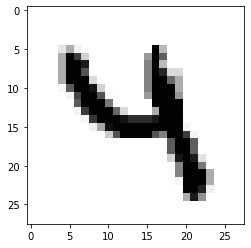

In [10]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()

    print('Accuracy:', accuracy.item())

    #Get one and Predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r: r+1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r: r+1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction).item())

    plt.imshow(mnist_test.test_data[r: r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

## Additional Section

Let's make our model clear as we've done always and let's make our accuracy and prediction check as a function with multiple datas

In [11]:
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        return self.linear(x)

In [12]:
model = MNIST_Classifier().to(device)

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

### Take a Moment!

```len(data_loader)```

returns the size of the each minibatch

Therefore, in our mnist dataset, we have 60,000 images, and the batch_size is 100, we have 600 mini batches.

So if we divide our mini batch cost by total amount of mini batch (600)

each mini batch cost / 600 * 600 (iteration: since we have 600 minibatch)

=> we will get cost for one mini batch for one epoch.

(We update our gradients by one minibatch)

In [14]:
nb_epochs = 20

for epoch in range(nb_epochs + 1):

    #Get average cost of each batch
    batch_cost = 0

    for X, Y in data_loader:

        #Change shape
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        #prediction
        pred = model(X)

        #cost
        cost = F.cross_entropy(pred, Y).to(device)

        #Reduce cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        #add cost
        batch_cost += cost / len(data_loader)
    print('Epoch: {:02d}/{}, Cost: {:.6f}'.format(epoch, nb_epochs, batch_cost))

Epoch: 00/20, Cost: 0.536617
Epoch: 01/20, Cost: 0.359027
Epoch: 02/20, Cost: 0.330956
Epoch: 03/20, Cost: 0.316481
Epoch: 04/20, Cost: 0.306736
Epoch: 05/20, Cost: 0.300188
Epoch: 06/20, Cost: 0.294988
Epoch: 07/20, Cost: 0.290778
Epoch: 08/20, Cost: 0.287224
Epoch: 09/20, Cost: 0.284532
Epoch: 10/20, Cost: 0.281796
Epoch: 11/20, Cost: 0.279714
Epoch: 12/20, Cost: 0.277764
Epoch: 13/20, Cost: 0.275730
Epoch: 14/20, Cost: 0.274276
Epoch: 15/20, Cost: 0.272796
Epoch: 16/20, Cost: 0.271504
Epoch: 17/20, Cost: 0.270395
Epoch: 18/20, Cost: 0.269118
Epoch: 19/20, Cost: 0.267896
Epoch: 20/20, Cost: 0.267050


### Take a Moment!

When I set above epochs as 100, the below accuracy shows only 7% of accuracy.
When I set the epochs as 20, the accuracy was up to 88%. It is the good example of showing overfitting.

## Accurcacy Tester

### Take a Moment!

**TORCH.RANDINT**

> torch.randint(low=0, high, size, *, generator=None, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor

Returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive).

The shape of the tensor is defined by the variable argument size.

**NOTE**

With the global dtype default (torch.float32), this function returns a tensor with dtype torch.int64.

**Parameters**

- low (int, optional) – Lowest integer to be drawn from the distribution. Default: 0.

- high (int) – One above the highest integer to be drawn from the distribution.

- size (tuple) – a tuple defining the shape of the output tensor.

Total accuracy of test set: 88.089996%
Label:  0
Prediction:  0


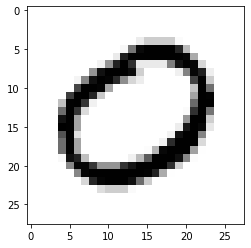

Label:  8
Prediction:  8


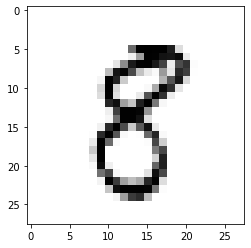

Label:  7
Prediction:  7


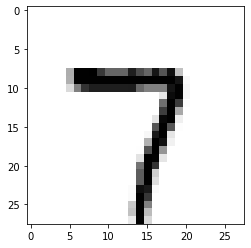

Label:  7
Prediction:  7


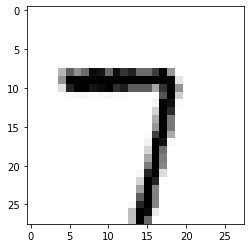

Label:  5
Prediction:  5


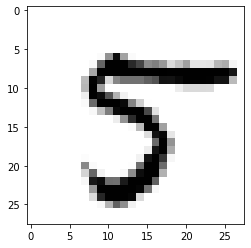

In [15]:
def accuracy_tester(pred_num):

    with torch.no_grad():
        X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
        Y_test = mnist_test.test_labels.to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()*100

        print('Total accuracy of test set: {:.6f}%'.format(accuracy.item()))

        #Get multiple and Predict
        r = random.randint(0, len(mnist_test) - pred_num)
        X_multiple_data = mnist_test.test_data[r: r+pred_num].view(-1, 28 * 28).float().to(device)
        Y_multiple_data = mnist_test.test_labels[r: r+pred_num].to(device)

        for i, data in enumerate(X_multiple_data):
            print('Label: ', Y_multiple_data[i].item())

            single = model(data)

            print('Prediction: ', torch.argmax(single).item())

            data = data.to('cpu')
            # if not above, the error : TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
            # Seems to enumerate method makes the tensor's feature corrupt.
            
            plt.imshow(data.view(28, 28), cmap='Greys', interpolation='nearest')
            plt.show()

accuracy_tester(5)